In [1]:
from pytorch_tabnet.tab_model import TabNetClassifier

import os
import torch
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
 
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Creditos a Diego Fernandez por el manejo de los datos.

In [2]:
folder1 = "Data"
ligas = ["Bundesliga", "Ligue-1", "Premier"]
años = ["19-20", "20-21", "21-22", "22-23", "23-24"]
torneos = []

for liga in ligas:
    for año in años:
        match_file = f"stats_{año}.csv"
        try:
            path_matches = os.path.join(folder1, liga, match_file)
            matches = pd.read_csv(path_matches)
        except FileNotFoundError:
            continue
        torneos.append(matches)

Se borran los partidos de cada torneo en los que no hay registro de los equipos que jugaron.

In [3]:
for torneo in torneos:
    torneo.dropna(subset=['team_home', 'team_away'], inplace=True)

Ahora, se eliminan las columnas que tengan datos faltantes.

In [4]:
columns_with_null = []

for torneo in torneos:
    null_columns = torneo.columns[torneo.isna().any()].tolist()
    columns_with_null.append(null_columns)

columns_with_null

unique_columns = list(set(itertools.chain.from_iterable(columns_with_null)))
unique_columns

#Borrar para cada torneo las columnas en unique_columns
for torneo in torneos:
    torneo.drop(columns=unique_columns, inplace=True)

In [5]:
torneos2 = []

for torneo in torneos:
    torneo.sort_values(by='number_of_match', inplace=True)
    torneo.rename(columns={'home_score': 'score_home', 'away_score': 'score_away'}, inplace=True)

    ##OJOO arreglar tema de equipos
    team_counts = pd.concat([torneo['team_home'], torneo['team_away']]).value_counts()
    teams_to_remove = team_counts[team_counts < 5].index

    torneo = torneo[~(torneo['team_home'].isin(teams_to_remove) | torneo['team_away'].isin(teams_to_remove))]
    torneos2.append(torneo)

In [6]:
torneos = torneos2
torneos[0].head()

#Cantidad de datos en cada torneo
for torneo in torneos:
    print(torneo.shape)

(305, 47)
(305, 47)
(193, 47)
(290, 47)
(234, 47)
(279, 47)
(380, 47)
(58, 47)
(378, 47)
(380, 47)
(374, 47)
(380, 47)
(132, 47)


Se generan las tablas para cada temporada.

In [7]:
def remove_suffix(item):
    return item.replace("_home", "").replace("_away", "")

column = [remove_suffix(item) for item in matches.columns]
columnas = []
[columnas.append(x) for x in column if x not in columnas]
columnas.remove("number_of_match")
columnas.remove("team")
columnas[0] = "score_prom"
print(columnas)
print(len(columnas))

['score_prom', 'posession', 'total_shots', 'shots_on_target', 'shots_off_target', 'blocked_shots', 'corner_kicks', 'fouls', 'red_cards', 'free_kicks', 'goal_kicks', 'shots_inside_box', 'shots_outside_box', 'passes', 'accurate_passes', 'long_balls', 'crosses', 'dribbles', 'duels_won', 'aerials_won', 'tackles', 'interceptions']
22


In [8]:
columnas.append("wins")
columnas.append("ties")
columnas.append("losses")
columnas.append("total_goals")
columnas.append("total_goals_conceded")
columnas.append("points")
columnas.append("streak")
columnas.append("wins_in_last_5_matches")
columnas.append("ties_in_last_5_matches")
columnas.append("losses_in_last_5_matches")

In [9]:
tablas = []

for torneo, i in zip(torneos, range(len(torneos))):
    
    equipos = torneo["team_home"].unique()
    equipos2 = torneo["team_away"].unique()
    print(len(equipos), len(equipos2))
    print(equipos)
    stats = columnas

    tabla = {}

    for equipo in equipos:

        tabla[equipo] = dict.fromkeys(stats, 0)
        tabla[equipo]["last_5_matches"] = list()

    tablas.append(tabla)

18 18
['Bayern München' 'Bayer 04 Leverkusen' 'Borussia Dortmund' 'Freiburg'
 'Werder Bremen' 'Wolfsburg' "Borussia M'gladbach" 'Eintracht Frankfurt'
 '1. FC Union Berlin' '1. FC Köln' '1. FSV Mainz 05' 'Augsburg'
 'Fortuna Düsseldorf' 'SC Paderborn 07' '1899 Hoffenheim' 'RB Leipzig'
 'Hertha BSC' 'FC Schalke 04']
18 18
['Bayern München' '1. FC Köln' '1. FC Union Berlin' 'Eintracht Frankfurt'
 'Werder Bremen' 'VfB Stuttgart' 'Borussia Dortmund' 'RB Leipzig'
 'VfL Wolfsburg' 'Hertha BSC' '1. FSV Mainz 05' 'Arminia Bielefeld'
 'Bayer 04 Leverkusen' "Borussia M'gladbach" 'FC Augsburg' 'FC Schalke 04'
 '1899 Hoffenheim' 'SC Freiburg']
18 18
["Borussia M'gladbach" '1. FC Union Berlin' 'Arminia Bielefeld'
 'FC Augsburg' 'VfB Stuttgart' 'VfL Wolfsburg' 'Borussia Dortmund'
 '1. FSV Mainz 05' '1. FC Köln' 'RB Leipzig' 'Eintracht Frankfurt'
 'Hertha BSC' 'SC Freiburg' 'SpVgg Greuther Fürth' 'VfL Bochum'
 'Bayer 04 Leverkusen' '1899 Hoffenheim' 'Bayern München']
23 23
['Eintracht Frankfurt' '1. F

In [10]:
new_stats = ["wins",
"ties",
"losses",
"total_goals",
"total_goals_conceded",
"points",
"streak",
"wins_in_last_5_matches",
"ties_in_last_5_matches",
"losses_in_last_5_matches"]
procesated_matches_columns = list(torneos[0].columns)
procesated_matches_columns.insert(5, "score_prom_away")
procesated_matches_columns.insert(5, "score_prom_home")

for stat in new_stats:
    procesated_matches_columns.append(f"{stat}_home")
    procesated_matches_columns.append(f"{stat}_away")

procesated_matches = pd.DataFrame(columns = procesated_matches_columns)

procesated_matches.head()

,number_of_match,team_home,team_away,score_home,score_away,score_prom_home,score_prom_away,posession_home,posession_away,total_shots_home,...,points_home,points_away,streak_home,streak_away,wins_in_last_5_matches_home,wins_in_last_5_matches_away,ties_in_last_5_matches_home,ties_in_last_5_matches_away,losses_in_last_5_matches_home,losses_in_last_5_matches_away


In [11]:
for torneo, i in zip(torneos, range(len(torneos))):
    tabla = tablas[i]
    for index in torneo.index:
    
        """Escribir info en el nuevo df de partidos con la información hasta el partido la cual esta almacenada en 'tabla'"""
        match = torneo.loc[index]
        team_home = match["team_home"]
        team_away = match["team_away"]

        stats_home = tabla[team_home]
        stats_away = tabla[team_away]

        fila = []
        fila.append(match["number_of_match"])
        fila.append(team_home)
        fila.append(team_away)
        fila.append(match["score_home"])
        fila.append(match["score_away"])

        for stat in stats:
            
            fila.append(tabla[team_home][stat])
            fila.append(tabla[team_away][stat])
        
        procesated_matches.loc[len(procesated_matches)] = fila
        
        """ Actualizar la tabla con lo que realmente ocurrió en ese partido"""

        matches_played_home = tabla[team_home]["wins"] + tabla[team_home]["ties"] + tabla[team_home]["losses"]+1
        matches_played_away = tabla[team_away]["wins"] + tabla[team_away]["ties"] + tabla[team_away]["losses"]+1
        
        ## stats promediadas:
        for stat in stats[:stats.index("wins")]:
            if stat == "score_prom":
                tabla[team_home][stat] = (tabla[team_home][stat]*(matches_played_home-1) + match["score_home"])/matches_played_home
                tabla[team_away][stat] = (tabla[team_away][stat]*(matches_played_away-1) + match["score_away"])/matches_played_away
            else:
                tabla[team_home][stat] = (tabla[team_home][stat]*(matches_played_home-1) + match[f"{stat}_home"])/matches_played_home
                tabla[team_away][stat] = (tabla[team_away][stat]*(matches_played_away-1) + match[f"{stat}_away"])/matches_played_away
            
        ## stats acumuladas
        
        empate = False
        if match["score_home"] > match["score_away"]:

            #victorias / derrotas
            tabla[team_home]["wins"] += 1
            tabla[team_away]["losses"] += 1

            #goles a favor
            tabla[team_home]["total_goals"] += match["score_home"]
            tabla[team_away]["total_goals"] += match["score_away"]

            #goles en contra
            tabla[team_home]["total_goals_conceded"] += match["score_away"]
            tabla[team_away]["total_goals_conceded"] += match["score_home"]

            #puntos
            tabla[team_home]["points"] += 3

            # racha
            tabla[team_home]["streak"] += 1
            tabla[team_away]["streak"] = 0

            # ultimos 5 partidos
            if len(tabla[team_home]["last_5_matches"]) == 5:
                tabla[team_home]["last_5_matches"].pop(0)
            if len(tabla[team_away]["last_5_matches"]) == 5:
                tabla[team_away]["last_5_matches"].pop(0)

            tabla[team_home]["last_5_matches"].append("W")
            tabla[team_away]["last_5_matches"].append("L")


        elif match["score_home"] < match["score_away"]:

            #victorias / derrotas
            tabla[team_away]["wins"] += 1
            tabla[team_home]["losses"] += 1

            #goles a favor
            tabla[team_away]["total_goals"] += match["score_away"]
            tabla[team_home]["total_goals"] += match["score_home"]

            #goles en contra
            tabla[team_away]["total_goals_conceded"] += match["score_home"]
            tabla[team_home]["total_goals_conceded"] += match["score_away"]

            #puntos
            tabla[team_away]["points"] += 3

            # racha
            tabla[team_away]["streak"] += 1
            tabla[team_home]["streak"] = 0

            # ultimos 5 partidos
            if len(tabla[team_home]["last_5_matches"]) == 5:
                tabla[team_home]["last_5_matches"].pop(0)
            if len(tabla[team_away]["last_5_matches"]) == 5:
                tabla[team_away]["last_5_matches"].pop(0)

            tabla[team_away]["last_5_matches"].append("W")
            tabla[team_home]["last_5_matches"].append("L")

        else:
            #empate
            tabla[team_home]["ties"] += 1
            tabla[team_away]["ties"] += 1

            #goles a favor
            tabla[team_home]["total_goals"] += match["score_home"]
            tabla[team_away]["total_goals"] += match["score_away"]

            #goles en contra
            tabla[team_home]["total_goals_conceded"] += match["score_away"]
            tabla[team_away]["total_goals_conceded"] += match["score_home"]

            #puntos
            tabla[team_home]["points"] += 1
            tabla[team_away]["points"] += 1

            # racha
            tabla[team_away]["streak"] += 1
            tabla[team_home]["streak"] += 1

            # ultimos 5 partidos
            if len(tabla[team_home]["last_5_matches"]) == 5:
                tabla[team_home]["last_5_matches"].pop(0)
            if len(tabla[team_away]["last_5_matches"]) == 5:
                tabla[team_away]["last_5_matches"].pop(0)

            tabla[team_away]["last_5_matches"].append("T")
            tabla[team_home]["last_5_matches"].append("T")

        tabla[team_home]["wins_in_last_5_matches"] = tabla[team_home]["last_5_matches"].count("W")
        tabla[team_home]["ties_in_last_5_matches"] = tabla[team_home]["last_5_matches"].count("T")
        tabla[team_home]["losses_in_last_5_matches"] = tabla[team_home]["last_5_matches"].count("L")

        tabla[team_away]["wins_in_last_5_matches"] = tabla[team_away]["last_5_matches"].count("W")
        tabla[team_away]["ties_in_last_5_matches"] = tabla[team_away]["last_5_matches"].count("T")
        tabla[team_away]["losses_in_last_5_matches"] = tabla[team_away]["last_5_matches"].count("L")

In [12]:
procesated_matches.tail()

,number_of_match,team_home,team_away,score_home,score_away,score_prom_home,score_prom_away,posession_home,posession_away,total_shots_home,...,points_home,points_away,streak_home,streak_away,wins_in_last_5_matches_home,wins_in_last_5_matches_away,ties_in_last_5_matches_home,ties_in_last_5_matches_away,losses_in_last_5_matches_home,losses_in_last_5_matches_away
3683,129,Everton,Manchester United,0.0,3.0,1.181818,1.083333,41.636364,54.250000,14.272727,...,13,21,2,2,3,4,0,0,2,1
3684,130,Fulham,Wolverhampton,3.0,2.0,0.833333,1.333333,48.750000,47.833333,11.083333,...,12,15,0,1,1,2,1,2,3,1
3685,131,Arsenal,Wolverhampton,2.0,1.0,2.076923,1.384615,61.230769,47.230769,14.538462,...,30,15,2,0,3,2,1,1,1,2
3686,132,Brentford,Luton Town,3.0,1.0,1.461538,0.923077,46.923077,35.769231,14.153846,...,16,9,0,1,3,1,0,2,2,2
3687,147,Aston Villa,Manchester City,1.0,0.0,2.384615,2.538462,52.538462,62.384615,14.923077,...,28,29,2,5,4,3,0,2,1,0


In [13]:
#Exportar a csv
procesated_matches.to_csv("procesated_matches_big_leagues.csv", index=False)

In [14]:
#Usamos el GPU si esta disponible, mps porque es apple silicon.
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f"using {device}")

using mps


In [15]:
matches = procesated_matches

#Aqui agrega la columna de resultados

results = []

for index in matches.index:

    match = matches.loc[index]
    if match["score_home"] > match["score_away"]:
        results.append(1)
    elif match["score_home"] < match["score_away"]:
        results.append(2)
    else:
        results.append(0)

matches["result"] = results

In [16]:
matches.head()

,number_of_match,team_home,team_away,score_home,score_away,score_prom_home,score_prom_away,posession_home,posession_away,total_shots_home,...,points_away,streak_home,streak_away,wins_in_last_5_matches_home,wins_in_last_5_matches_away,ties_in_last_5_matches_home,ties_in_last_5_matches_away,losses_in_last_5_matches_home,losses_in_last_5_matches_away,result
0,0,Bayern München,Hertha BSC,2.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,1,Bayer 04 Leverkusen,SC Paderborn 07,3.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,2,Borussia Dortmund,Augsburg,5.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,3,Freiburg,1. FSV Mainz 05,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,4,Werder Bremen,Fortuna Düsseldorf,1.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,2


In [17]:
#Cantidad de partidos por resultado (local, empate, visita)
for i in range(0,3):
    cantidad = matches[matches["result"]==i].shape[0]
    print(f"Resultado {i}, hay: {cantidad} partidos, {cantidad*100/len(matches)}%")

Resultado 0, hay: 883 partidos, 23.942516268980476%
Resultado 1, hay: 1605 partidos, 43.51952277657267%
Resultado 2, hay: 1200 partidos, 32.53796095444685%


In [18]:
#Ahora,vamos a separar el último torneo

cant_partidos_ultima_temp = len(torneos[-1])

matches_train = matches.iloc[:-cant_partidos_ultima_temp]
matches_test = matches.iloc[-cant_partidos_ultima_temp:]

result_train = matches_train["result"]
result_test = matches_test["result"]
matches_train = matches_train.drop(columns = ["team_home", "team_away", "result", "score_home", "score_away", "number_of_match"])
matches_test = matches_test.drop(columns = ["team_home", "team_away", "result", "score_home", "score_away", "number_of_match"])

matches_train.tail(), matches_test.tail()

(      score_prom_home  score_prom_away  posession_home  posession_away  \
 3551         0.891892         1.142857       42.702703       40.500000   
 3552         1.270270         1.783784       46.810811       50.000000   
 3553         1.324324         0.880000       47.648649       44.120000   
 3554         1.513514         1.459459       53.810811       48.675676   
 3555         0.864865         1.918919       44.837838       60.810811   
 
       total_shots_home  total_shots_away  shots_on_target_home  \
 3551         11.243243         11.142857              3.945946   
 3552         11.972973         13.702703              3.864865   
 3553         10.945946         12.880000              4.000000   
 3554         15.459459         11.324324              5.594595   
 3555         10.864865         15.540541              3.567568   
 
       shots_on_target_away  shots_off_target_home  shots_off_target_away  ...  \
 3551              4.000000               4.054054            

In [19]:
result = matches["result"]
matches = matches.drop(columns = ["team_home", "team_away", "result", "score_home", "score_away"])
matches.head()

columnas_categoricas = matches.select_dtypes(include=['object']).columns.tolist()

print("Columnas categóricas:")
print(columnas_categoricas)

Columnas categóricas:
[]


In [20]:
# Convertir columnas categoricas a numericas

#col = LabelEncoder().fit(matches["columna_tabla"])
#data["columna_tabla"] = col.transform(matches["columna_tabla"])

In [21]:
'''
X = matches.to_numpy()
scaler = StandardScaler()
X_escalados = scaler.fit_transform(X)
y = result
'''

X = matches_train.to_numpy()
scaler = StandardScaler()
X_train = scaler.fit_transform(X)
y_train = result_train

X_test = scaler.transform(matches_test.to_numpy())
y_test = result_test

In [22]:
#X_train, X_test, y_train, y_test = train_test_split(X_escalados, y, test_size=0.3, random_state = 1, stratify=y)

In [23]:
#kfold = KFold(n_splits=5)

#y_true_all = []
#y_pred_all = []

#for train_index, test_index in kfold.split(X_escalados):
#X_train, X_test = X_escalados[train_index], X_escalados[test_index]
#y_train, y_test = y[train_index], y[test_index]
clf = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=1e-3),
    scheduler_params={"step_size":50, # how to use learning rate scheduler
                        "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='entmax', # "sparsemax" "entmax"
    )
    
clf.fit(X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    eval_name=['train', 'valid'], 
    eval_metric=['accuracy'], 
    max_epochs=1000 , patience=100, 
    batch_size=28, drop_last=False)

pred = clf.predict(X_test)
# Almacenar las predicciones
#y_true_all.extend(y_test)
#y_pred_all.extend(pred)

/Users/gustavofernandez/Desktop/pytorch-test/env/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.22257 | train_accuracy: 0.40439 | valid_accuracy: 0.43182 |  0:00:01s
epoch 1  | loss: 1.15602 | train_accuracy: 0.42492 | valid_accuracy: 0.47727 |  0:00:02s
epoch 2  | loss: 1.12285 | train_accuracy: 0.44798 | valid_accuracy: 0.5     |  0:00:03s
epoch 3  | loss: 1.10964 | train_accuracy: 0.44123 | valid_accuracy: 0.5     |  0:00:04s
epoch 4  | loss: 1.1112  | train_accuracy: 0.47132 | valid_accuracy: 0.51515 |  0:00:06s
epoch 5  | loss: 1.09193 | train_accuracy: 0.48875 | valid_accuracy: 0.52273 |  0:00:07s
epoch 6  | loss: 1.07724 | train_accuracy: 0.48172 | valid_accuracy: 0.52273 |  0:00:08s
epoch 7  | loss: 1.07039 | train_accuracy: 0.49297 | valid_accuracy: 0.55303 |  0:00:09s
epoch 8  | loss: 1.0634  | train_accuracy: 0.49691 | valid_accuracy: 0.51515 |  0:00:10s
epoch 9  | loss: 1.06401 | train_accuracy: 0.49494 | valid_accuracy: 0.56061 |  0:00:11s
epoch 10 | loss: 1.05589 | train_accuracy: 0.49522 | valid_accuracy: 0.5     |  0:00:12s
epoch 11 | loss: 1.05

/Users/gustavofernandez/Desktop/pytorch-test/env/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [24]:
print("classification report")
print(classification_report(y_test, pred))

classification report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.62      0.85      0.72        61
           2       0.54      0.57      0.55        46

    accuracy                           0.59       132
   macro avg       0.39      0.47      0.42       132
weighted avg       0.47      0.59      0.52       132



/Users/gustavofernandez/Desktop/pytorch-test/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gustavofernandez/Desktop/pytorch-test/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gustavofernandez/Desktop/pytorch-test/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

Normalized confusion matrix


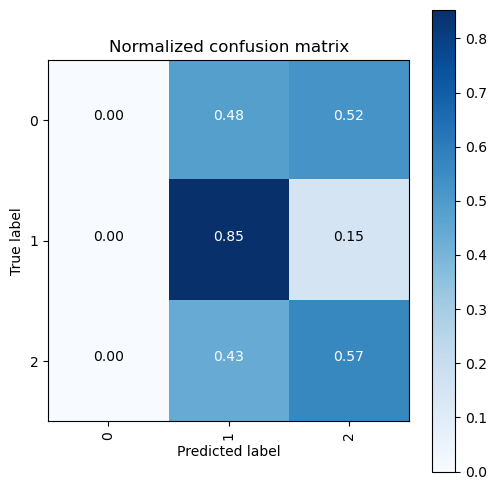

In [25]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

cnf_matrix = confusion_matrix(y_test, pred)
classes = np.unique(y_train)
np.set_printoptions(precision=2)
# Plot normalized confusion matrix
plt.figure(figsize=(5,5))

plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True, title='Normalized confusion matrix')

plt.show()